In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15.0, 7.0)

popt = [8.66260100e-14 7.42094990e-04 9.56570375e-06 8.25390151e-13]
perr = [5.30947209e-02 7.67360171e-03 2.77080951e-04 7.39873238e+01]


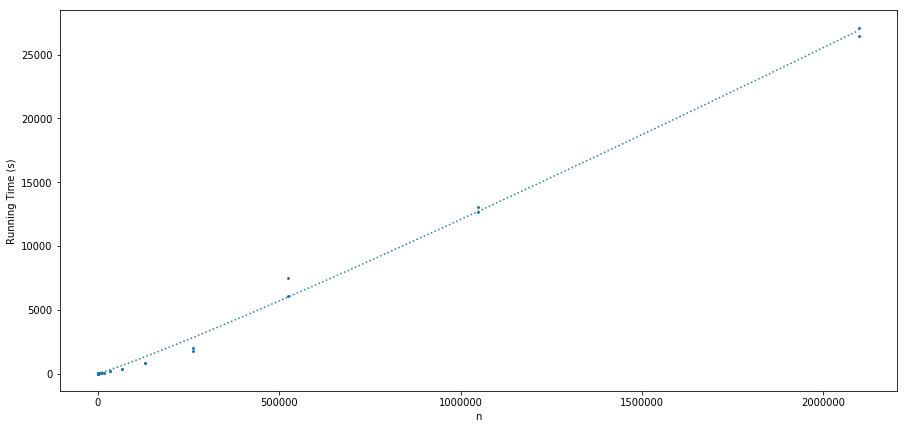

In [2]:
from scipy.optimize import curve_fit
data_filenames=["../benchmark_scs_linear.txt", "../benchmark_scs_exponential.txt"]
for filename in data_filenames[1:]:
    raw_data = []
    with open(filename) as f:
        cur_len = 0.
        for line in f.read().splitlines():
            fields = line.split()
            if fields[0] ==  'len':
                cur_len = fields[2]
            if fields[0] == 'Time':
                raw_data += [[cur_len, fields[2]]]
            
    data = np.array(raw_data, dtype=np.float64)
    data[:,1] /= 1000. # ms -> s

    plt.scatter(data[:,0], data[:,1], s=4, marker='x')

    # estimate the parameters a,b,c,d
    # of the running time a*n + b*nlogn + c*n(logn)^2 + d
    def f_scs(n, a, b, c, d):
        return a*n + b*n*np.log(n) + c*n*(np.log(n)**2) + d

    popt, pcov = curve_fit(f_scs, data[:,0], data[:,1], bounds=(0., np.inf))
    perr = np.sqrt(np.diag(pcov))
    print("popt =", popt)
    print("perr =", perr)
    
    model_scs = lambda data: f_scs(data, *popt)

    n_values = np.arange(1, max(data[:,0]), 10)
    plt.plot(n_values, f_scs(n_values, *popt), ':')
    plt.xlabel("n")
    plt.ylabel("Running Time (s)")

plt.show()

[ 4.18700660e-01 -1.93861019e-02  4.74349119e+03  1.33252578e-06
  1.46934693e-03]


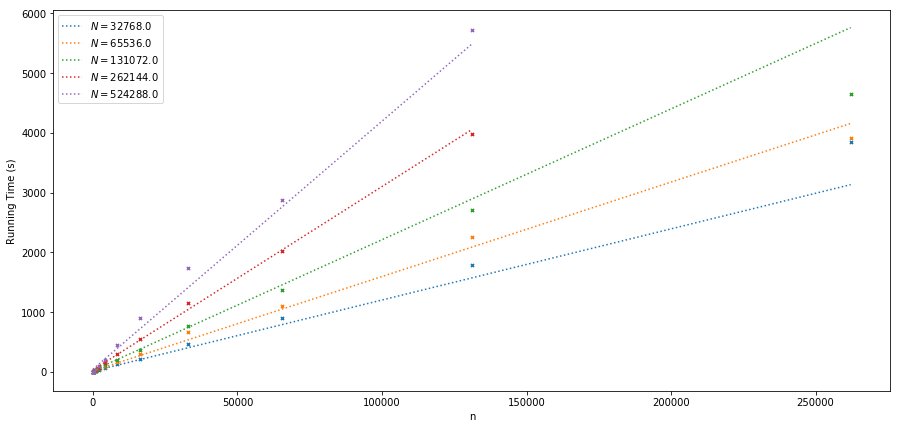

In [3]:
from scipy.optimize import curve_fit,least_squares
filename = "../benchmark_fss_exponential.txt"
raw_data=[]
with open(filename) as f:
    len_server = 0.
    len_client = 0.
    for line in f.read().splitlines():
        fields = line.split()
        if fields[0] == 'len_server':
            len_server = fields[2]
        if fields[0] == 'len_client':
            len_client = fields[2]
        if fields[0] == 'Time' :#and float(len_server) > 4 and float(len_client) > 4 :#and float(len_client) <32000:
            raw_data += [[len_server, len_client, fields[2]]]
            
data = np.array(raw_data, dtype=np.float64)
data[:,2] /= 1000. # ms -> s

#data = data[np.where((data[:,0] >= 1024) & (data[:,1] >= 1024))]

# fit to running time of the form (a*n_server + b*n_server*log(n_server) + c) * (d * n_client + e)
def f_fss(data, a,b,c,d,e):
    return (a*data[:,0] + b*data[:,0]*np.log2(data[:,0]) + c) * (d*data[:,1] + e)
def res(x, data=(data[:,:2]), y=(data[:,2])):
    return f(data, *x) - y



initial_guess = [1,1,1,1,1]
#opt = least_squares(res, initial_guess, loss='linear').x
opt, _ = curve_fit(f_fss, data[:,:2], data[:,2])

model_fss = lambda data: f_fss(data, *opt)

print(opt)

for (i, len_server) in enumerate(np.unique(data[:,0])[-5:]):
    cur_data = data[np.where(data[:,0] == len_server)]
    plt.scatter(cur_data[:,1], cur_data[:,2], s=10, marker='x')
    #plt.plot(cur_data[:,1], 2**f(np.log2(cur_data[:,:2]), *opt), ':', label = "$N = {}$".format(len_server))
    plt.plot(cur_data[:,1], model_fss(cur_data[:,:2]), ':', label = "$N = {}$".format(len_server))
    

#plt.xscale('log')
#plt.yscale('log')
plt.xlabel("n")
plt.ylabel("Running Time (s)")
plt.legend(loc=2)
plt.show()

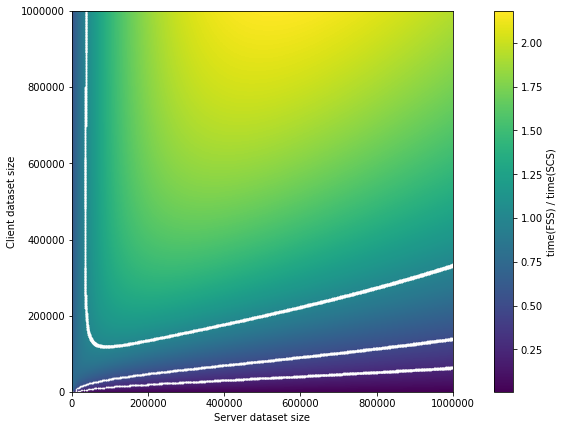

In [4]:
from scipy.interpolate import griddata

server_sizes = np.arange(1000, 10**6, 1000)
client_sizes = np.arange(1000, 10**6, 1000)

def cartesian_product(x, y):
    # https://stackoverflow.com/q/11144513
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

def model_scs_sum(data):
    return model_scs(data[:,0] + data[:,1])
    
sizes = cartesian_product(server_sizes, client_sizes)
times_fss = model_fss(sizes)
#times_fss_2 = model_fss(np.flip(sizes, 1))
#times_fss = np.minimum(times_fss_2, times_fss)
times_scs = model_scs_sum(sizes)

z = (times_fss / times_scs).reshape((len(client_sizes), len(server_sizes))) # x-axis is inner dimension for imshow
plt.imshow(z, origin='lower', extent=(min(server_sizes), max(server_sizes), min(client_sizes), max(client_sizes)))
cb = plt.colorbar()
cb.set_label('time(FSS) / time(SCS)')
# draw line for ratio == 1
equal = sizes[np.where(np.abs(times_fss/times_scs - 1) < 7e-3)]
plt.scatter(equal[:,0], equal[:,1], s=1, marker = ".", color="white")
equal = sizes[np.where(np.abs(times_fss/times_scs - 0.5) < 7e-3)]
plt.scatter(equal[:,0], equal[:,1], s=1, marker = ".", color="white")
equal = sizes[np.where(np.abs(times_fss/times_scs - 0.25) < 7e-3)]
plt.scatter(equal[:,0], equal[:,1], s=1, marker = ".", color="white")
plt.xlim((min(server_sizes), max(server_sizes)))
plt.ylim((min(client_sizes), max(client_sizes)))

#fss_better = sizes[np.where(times_fss < times_scs)]
#plt.scatter(fss_better[:,0], fss_better[:,1], s=1, label="FSS is faster than SCS")
plt.xlabel("Server dataset size")
plt.ylabel("Client dataset size")
plt.savefig('benchmarks.pdf', bbox_inches='tight')
plt.show()

z = (times_fss).reshape((len(client_sizes), len(server_sizes)))